In [1]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
import logging
import os
import cProfile
import pstats
from dataloader import *

from get_data import *

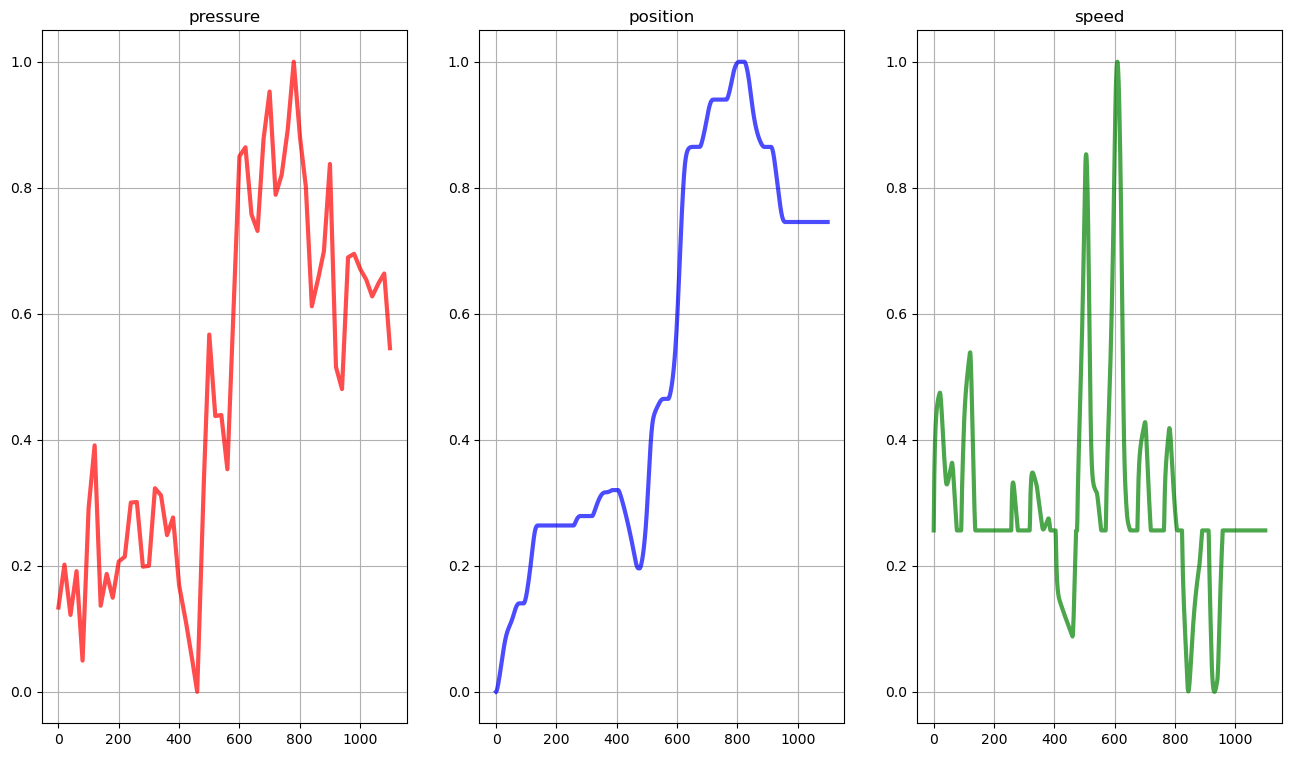

In [20]:
visualise(get_data(path = "save_data_test2.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w=True, rescale_p=False, num_inits=100), num_inits=100)